<a href="https://colab.research.google.com/github/Gakkilovemath/deep_credit/blob/main/notebooks/merton_in_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import jax
import jax.scipy
from jax.scipy import special as Sfn
from jax import numpy as jnp
from jax import grad
import numpy as np
from jax import value_and_grad
import matplotlib.pyplot as plt

# utils

In [2]:
# utils 
_SQRT_2 = jnp.sqrt(2.)

# cds function
def N(x):
    # cdf function for standard normal distribution.
  return (Sfn.erf(x / _SQRT_2) + 1) / 2


# black sholes call option price
def black_sholes_call_price(S0, K, r, sigma, T):
    # option prices for calls
    # T is the time to maturity
    d1 = (jnp.log(S0 / K) + (r + sigma ** 2 / 2) * T) / sigma * jnp.sqrt(T)
    d2 = d1 - sigma * jnp.sqrt(T)
    call = S0 * N(d1) - K * jnp.exp(- r * T) * N(d2)
    return call


# normalization constant
APPROX_CONSTANT = 2 / jnp.pi # 2/pi


# approximate implied vol functions
def approx_implied_vol(C0, S0, K, r, T):
    F = S0 * jnp.exp(r * T)
    y = jnp.log(F / K)
    alpha_c = C0 / (K * jnp.exp(-r * T))
    R = 2 * alpha_c - jnp.exp(y) + 1
    A = (jnp.exp((1-APPROX_CONSTANT) * y) - jnp.exp(-(1-APPROX_CONSTANT) * y)) ** 2
    B = 4 * (jnp.exp(APPROX_CONSTANT * y) + jnp.exp(-APPROX_CONSTANT * y)) - 2 * jnp.exp(-y) * (jnp.exp((1-APPROX_CONSTANT) * y) + jnp.exp(-(1-APPROX_CONSTANT) * y)) * (jnp.exp(2*y)+1-R**2)
    C = jnp.exp(-2 * y) * (R ** 2 - (jnp.exp(y) - 1) ** 2) * ((jnp.exp(y) + 1) ** 2 - R ** 2)
    beta = 2 * C / (B + jnp.sqrt(B ** 2 + 4 * A * C))
    gamma = - (1 / APPROX_CONSTANT) * jnp.log(beta)

    if y >= 0:
        C_thres = K * jnp.exp(- r * T) * (jnp.exp(y) * A * jnp.sqrt(2*y) - 1/2)
        if C0 <= C_thres:
            iv = (1 / jnp.sqrt(T)) * (jnp.sqrt(gamma + y) - jnp.sqrt(gamma - y))
        else:
            iv = (1 / jnp.sqrt(T)) * (jnp.sqrt(gamma + y) + jnp.sqrt(gamma - y))
    
    if y < 0:
        C_thres = K * jnp.exp(- r * T) * (jnp.exp(y) / 2 + A * jnp.sqrt(-2*y))
        if C0 <= C_thres:
            iv = (1 / jnp.sqrt(T)) * (- jnp.sqrt(gamma + y) + jnp.sqrt(gamma - y))
        else:
            iv = (1 / jnp.sqrt(T)) * (jnp.sqrt(gamma + y) + jnp.sqrt(gamma - y))
    return iv



def implied_vol(C0, S0, K, r, T, initial_vol=None, relative_tolerance=1e-12,
                max_iterations=100):
    """Computes implied volatilities from given call prices.
    """
    if initial_vol is None:
        initial_vol = approx_implied_vol(C0, S0, K, r, T)
    def loss(sigma):
        pricer = black_sholes_call_price(S0, K, r, sigma, T)
        return ((pricer - C0) ** 2).sum()
    # initilization
    implied_vol = initial_vol
    # docuemnt loss
    loss_present = loss(implied_vol)
    for i in range(max_iterations):
        # calculate the gradient
        loss_next, g_sigma = value_and_grad(loss)(implied_vol)
        h_sigma = grad(grad(loss))(iv)
        # update the parameters
        implied_vol = implied_vol - g_sigma * (1 / h_sigma)
        if np.abs(loss_next - loss_present) / loss_present < relative_tolerance:
            break
        loss_present = loss_next
    return implied_vol



# Black-Sholes option pricing

In [3]:
# The Greeks with Jax’s automatic differentiation using the grad function.
# s0
bs_delta = grad(black_sholes_call_price, argnums=0)
# s0
bs_gamma = grad(bs_delta, argnums=0)
# sigma
bs_vega = grad(black_sholes_call_price, argnums=3)
# T
bs_theta = grad(black_sholes_call_price, argnums=4)
# T
bs_rho = grad(black_sholes_call_price, argnums=2)

In [4]:
S0, K, r, sigma, T = 100., 103., 0.03, 0.6, 1.

C0 = black_sholes_call_price(S0, K, r, sigma, T)
print(f"call price at {C0}")
delta = bs_delta(S0, K, r, sigma, T)
print(f"autograd delta is {delta}")
d1 = (jnp.log(S0 / K) + (r + sigma ** 2 / 2) * T) / sigma * jnp.sqrt(T)
delta_cal = N(d1)
print(f"calculated delta is {delta_cal}")

call price at 23.59914779663086
autograd delta is 0.6181918382644653
calculated delta is 0.6181918382644653


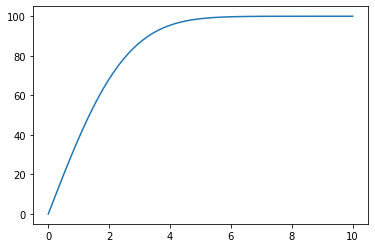

In [5]:
# plot the c0 as function of sigma when K is smaller then S0
volatilities = jnp.linspace(start=0., stop=10., num=1000)
c0 = [black_sholes_call_price(S0, K, r, sigma, T) for sigma in volatilities]
plt.plot(volatilities, c0)

In [6]:
if 0:
    # Price a batch of 5 vanilla call options.
    sigma_list = np.array([0.0001, 102.0, 2.0, 0.1, 0.4])
    S0_list = np.array([1.0, 2.0, 3.0, 4.0, 5.0])
    # Strikes will automatically be broadcasted to shape
    K_list = np.array([3.0])
    # Expiries will be broadcast to shape [5], i.e. each option has strike=3 and expiry = 1.
    T_list = 1.0
    r_list = 0.3

    black_sholes_call_price(S0=S0_list, K=K_list, r=r_list, sigma=sigma_list, T=T_list)

# Implied Volatility

Approximates the implied vol using the Stefanica-Radiocic algorithm.

Finds an approximation to the implied vol using the Polya approximation for
  the Normal CDF. This algorithm was described by Stefanica and Radiocic in
  ref [1]. They show that if the Normal CDFs appearing in the Black Scholes
  formula for the option price are replaced with Polya's approximation, the
  implied vol can be solved for analytically. The Polya approximation produces
  absolute errors of less than 0.003 and the resulting implied vol is fairly
  close to the true value. For practical purposes, this may not be accurate
  enough so this result should be used as a starting point for some method with
  controllable tolerance (e.g. a root finder).

  
**References**:

  [1]: Dan Stefanica and Rados Radoicic. An explicit implied volatility formula.
    International Journal of Theoretical and Applied Finance,
    Vol. 20, no. 7, 2017.
    https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2908494

  [2]: Omar Eidous, Samar Al-Salman. One-term approximation for Normal
    distribution function. Mathematics and Statistics 4(1), 2016.
    http://www.hrpub.org/download/20160229/MS2-13405192.pdf

In [7]:
C0, S0, K, r, T, sigma

(DeviceArray(23.599148, dtype=float32, weak_type=True),
 100.0,
 103.0,
 0.03,
 1.0,
 0.6)

In [8]:
# approximate vol
iv = approx_implied_vol(C0, S0, K, r, T)
iv

DeviceArray(0.59959626, dtype=float32, weak_type=True)

In [9]:
C0, S0, K, r, T

(DeviceArray(23.599148, dtype=float32, weak_type=True),
 100.0,
 103.0,
 0.03,
 1.0)

In [10]:
implied_vol(C0, S0, K, r, T), sigma

(DeviceArray(0.5999999, dtype=float32, weak_type=True), 0.6)